# Vehicle Detection
This notebook contains a all of the code that I used to explore different colorspaces and parameters for feature extraction and analyzed their effects on classifier accuracy.  All of the acutal video implementation is contained in the TrainClassifier.ipynb.

## Import Necessary Modules

In [1]:
import numpy as np
import cv2
import sys
import glob
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from sklearn import grid_search
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from scipy.ndimage.measurements import label

## Data Preparation
### Load All Training Data

In [2]:
car = glob.glob('train_data/vehicles/**/*.png')
non_car = glob.glob('train_data/non-vehicles/**/*.png')

car_images = []
non_car_images = []

for file in car:
    image = cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB)
    car_images.append(image)
    
for file in non_car:
    image = cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB)
    non_car_images.append(image)

image_data = {"car_images" : car_images,
              "non_car_images" : non_car_images}

pickle.dump(image_data, open("pickles/image_data.p", "wb"))
print("Image data saved to \"image_data.p\"")

Image data saved to "image_data.p"


### Visualize the Data

There are 8792 car images.
There are 8968 non-car images


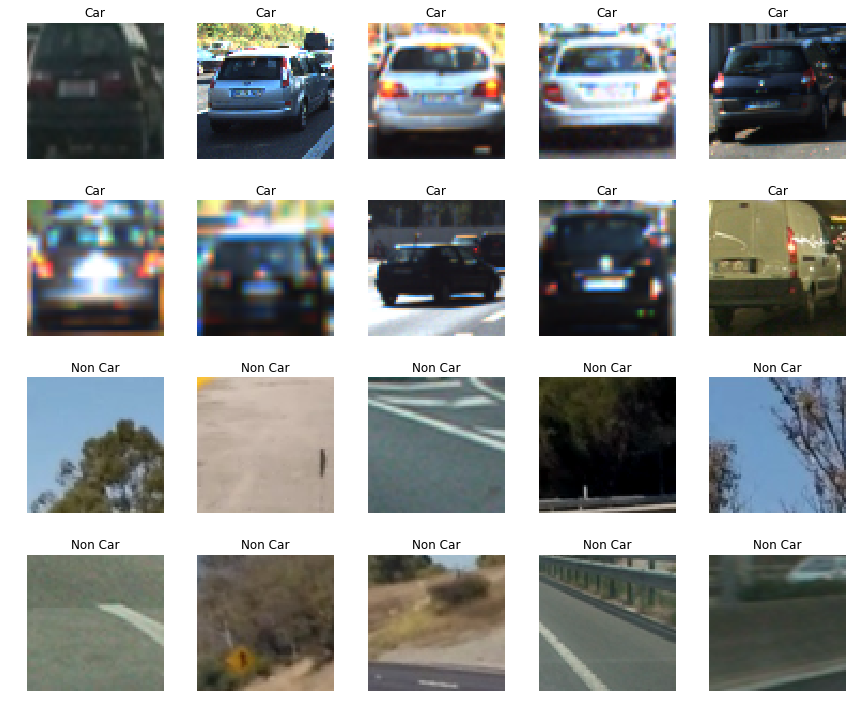

In [22]:
print('There are', len(car), 'car images.')
print('There are', len(non_car), 'non-car images')

fig_1 = plt.figure(figsize=(12,10))

for i in range(20):
    
    index = i+1
    if index < 11:
        image = cv2.imread(car[np.random.randint(0,len(car))])
        title = 'Car'
    else:
        image = cv2.imread(non_car[np.random.randint(0,len(non_car))])
        title = 'Non Car'
    
    fig_1.add_subplot(4,5, index)
    plt.title(title)
    plt.axis('off')
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

fig_1.tight_layout()
plt.savefig('output_images/data_vis.png')
plt.show()
    
    


## Colorspace Exploration

In [3]:
def color_hist(img, nbins=32, bins_range=(0, 256), split_vec=False):

    ch1 = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ch2 = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    ch3 = np.histogram(img[:,:,2], bins=nbins, range=bins_range)

    # Generating bin centers
    bin_edges = ch1[1]
    bin_centers = (bin_edges[1:] + bin_edges[0:len(bin_edges)-1])/2

    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((ch1[0], ch2[0], ch3[0]))
    hist_list = []
    hist_list.append(ch1[0])
    hist_list.append(ch2[0])
    hist_list.append(ch3[0])
    if(split_vec):
        return hist_list, bin_centers
    else:
        return hist_features

def color_hist_bulk(images, nbins=32, bins_range=(0, 256), colorspace='rgb'):
    
    all_features = []
    
    n_imgs = len(images)
    counter = 1
    
    for img in images:
        if colorspace == 'rgb':
            img = img
        elif colorspace == 'hsv':
            img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        elif colorspace == 'hls':
            img = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        elif colorspace == 'lab':
            img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        elif colorspace == 'yuv':
            img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
        elif colorspace == 'ycrcb':
            img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        elif colorspace == 'luv':
            img = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
   
        ch1 = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
        ch2 = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
        ch3 = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
        # Generating bin centers
        bin_edges = ch1[1]
        bin_centers = (bin_edges[1:] + bin_edges[0:len(bin_edges)-1])/2
    
        # Concatenate the histograms into a single feature vector
        hist_features = np.concatenate((ch1[0], ch2[0], ch3[0]))
        all_features.append(hist_features)
        
        sys.stdout.write("\rExtracting features for image %i of %i" % (counter, n_imgs))
        sys.stdout.flush()
        
        counter += 1
    
    return all_features

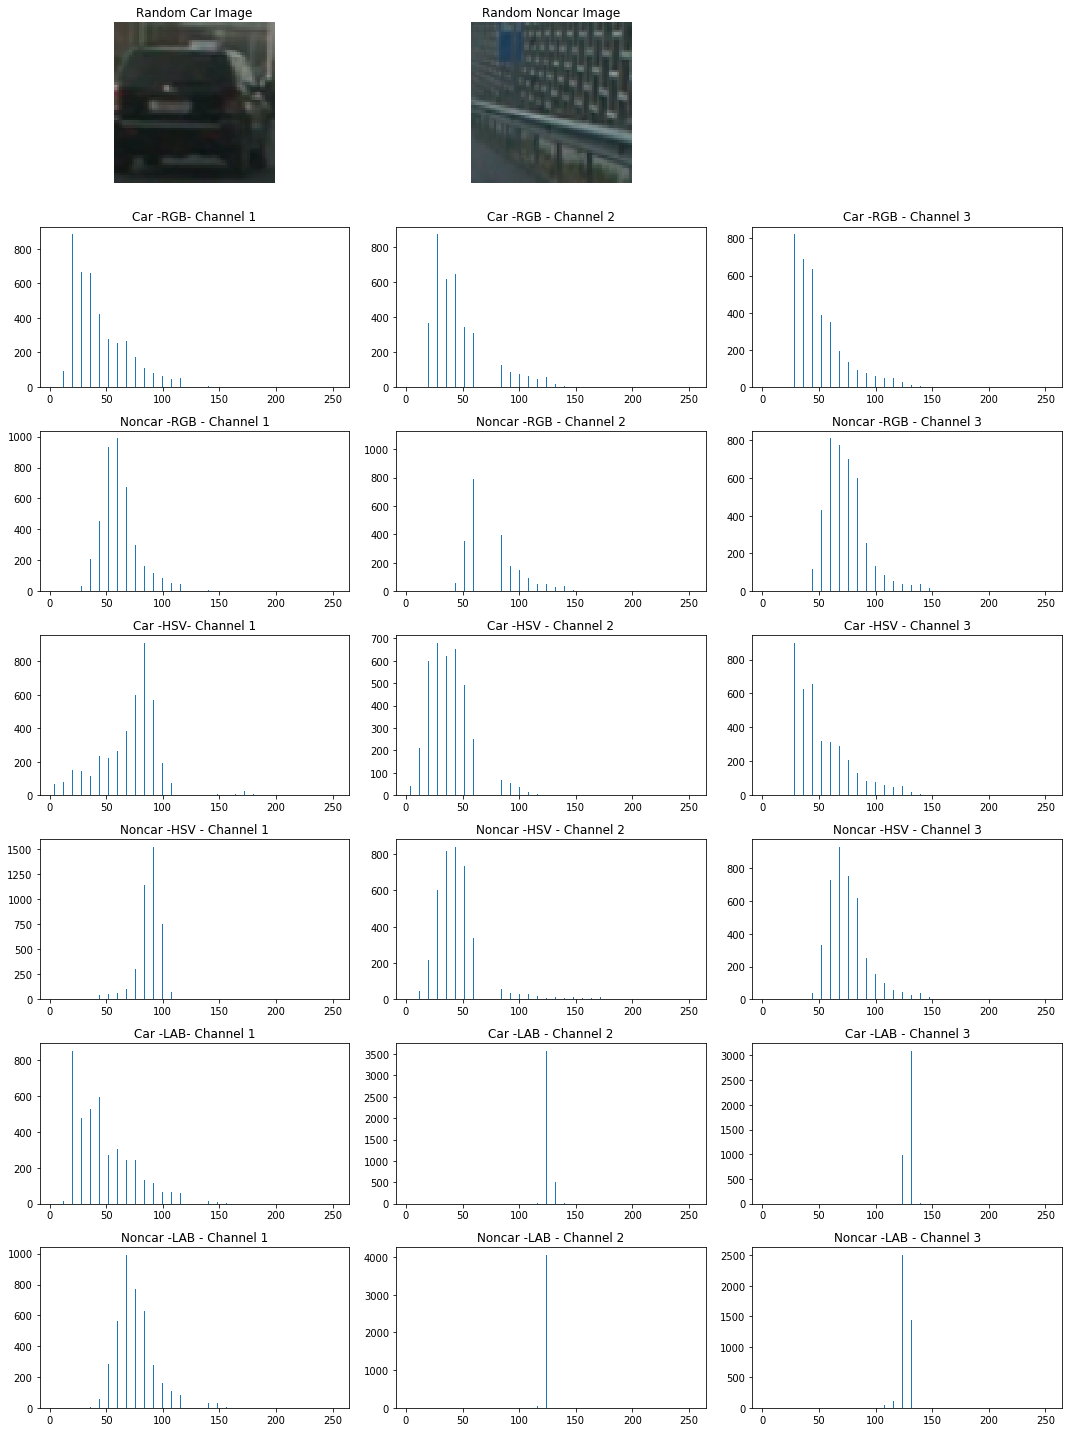

In [45]:
rnd_car = car_images[np.random.randint(0, len(car_images))]
rnd_noncar = non_car_images[np.random.randint(0, len(non_car_images))]

rgb_car_hist, bc = color_hist(rnd_car, split_vec=True)
rgb_noncar_hist, bc = color_hist(rnd_noncar, split_vec=True)

hsv_car_hist, bc = color_hist(cv2.cvtColor(rnd_car, cv2.COLOR_RGB2HSV), split_vec=True)
hsv_noncar_hist, bc = color_hist(cv2.cvtColor(rnd_noncar, cv2.COLOR_RGB2HSV), split_vec=True)

lab_car_hist, bc = color_hist(cv2.cvtColor(rnd_car, cv2.COLOR_RGB2LAB), split_vec=True)
lab_noncar_hist, bc = color_hist(cv2.cvtColor(rnd_noncar, cv2.COLOR_RGB2LAB), split_vec=True)

car_hists = []
noncar_hists = []

car_hists.append(rgb_car_hist)
car_hists.append(hsv_car_hist)
car_hists.append(lab_car_hist)
noncar_hists.append(rgb_noncar_hist)
noncar_hists.append(hsv_noncar_hist)
noncar_hists.append(lab_noncar_hist)

hist_fig = plt.figure(figsize=(15,20))

hist_fig.add_subplot(7,3,1)
plt.title('Random Car Image')
plt.axis('off')
plt.imshow(rnd_car)

hist_fig.add_subplot(7,3,2)
plt.title('Random Noncar Image')
plt.axis('off')
plt.imshow(rnd_noncar)

i = 0
labels = ['RGB', 'HSV', 'LAB']

for car, noncar in zip(car_hists, noncar_hists):
    hist_fig.add_subplot(7,3, 4+(i*6))
    plt.title(('Car -' + labels[i] + '- Channel 1'))
    plt.bar(bc, car[0])
    
    hist_fig.add_subplot(7,3, 5+(i*6))
    plt.title(('Car -' + labels[i] + ' - Channel 2'))
    plt.bar(bc, car[1])
    
    hist_fig.add_subplot(7,3, 6+(i*6))
    plt.title(('Car -' + labels[i] + ' - Channel 3'))
    plt.bar(bc, car[2])    
    
    hist_fig.add_subplot(7,3, 7+(i*6))
    plt.title(('Noncar -' + labels[i] + ' - Channel 1'))
    plt.bar(bc, noncar[0])
    
    hist_fig.add_subplot(7,3, 8+(i*6))
    plt.title(('Noncar -' + labels[i] + ' - Channel 2'))
    plt.bar(bc, noncar[1])
    
    hist_fig.add_subplot(7,3, 9+(i*6))
    plt.title(('Noncar -' + labels[i] + ' - Channel 3'))
    plt.bar(bc, noncar[2])
                         
    i += 1
    
hist_fig.tight_layout()
plt.savefig('output_images/histogram_fig.png')
plt.show()


In [46]:
colors = ['rgb', 'hsv', 'hls', 'lab', 'yuv', 'ycrcb', 'luv']
bins = [8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48]

color_acc = []
for color in colors:
        
    nbins_acc = []
    for nbin in bins:
        
        car_features = []
        non_car_features = []
        car_labels = []
        non_car_labels = []
        
        img_index = 0
        
        car_features = color_hist_bulk(car_images, nbins=nbin, colorspace = color)
        non_car_features = color_hist_bulk(non_car_images, nbins=nbin, colorspace = color)
        
        X = np.vstack((car_features, non_car_features)).astype(np.float64)
        y = np.hstack((np.ones(len(car_features)), np.zeros(len(non_car_features))))
        
        X_scaler = StandardScaler().fit(X)
        scaled_X = X_scaler.transform(X)
        
        X_train, X_valid, y_train, y_valid = train_test_split(scaled_X, y, test_size=0.2, random_state =15)
                
        svc = LinearSVC()
        svc.fit(X_train, y_train)
        score = svc.score(X_valid, y_valid)
        nbins_acc.append(score)
        print("--")
        print("For colorspace:", color, "and nbin value:" , nbin)
        print("SVC accuracy is:", score)
        print("-------------------------------------------")
    
    color_acc.append(nbins_acc)

colorspace_accuracy = {"color_acc" : color_acc}
pickle.dump(colorspace_accuracy, open("pickles/colorspace_accuracy.p", "wb"))


        

Extracting features for image 8968 of 8968--
For colorspace: rgb and nbin value: 8
SVC accuracy is: 0.842623873874
-------------------------------------------
Extracting features for image 8968 of 8968--
For colorspace: rgb and nbin value: 12
SVC accuracy is: 0.85670045045
-------------------------------------------
Extracting features for image 8968 of 8968--
For colorspace: rgb and nbin value: 16
SVC accuracy is: 0.888795045045
-------------------------------------------
Extracting features for image 8968 of 8968--
For colorspace: rgb and nbin value: 20
SVC accuracy is: 0.898648648649
-------------------------------------------
Extracting features for image 8968 of 8968--
For colorspace: rgb and nbin value: 24
SVC accuracy is: 0.905686936937
-------------------------------------------
Extracting features for image 8968 of 8968--
For colorspace: rgb and nbin value: 28
SVC accuracy is: 0.908502252252
-------------------------------------------
Extracting features for image 8968 of 8968

Extracting features for image 8968 of 8968--
For colorspace: yuv and nbin value: 40
SVC accuracy is: 0.930743243243
-------------------------------------------
Extracting features for image 8968 of 8968--
For colorspace: yuv and nbin value: 44
SVC accuracy is: 0.931306306306
-------------------------------------------
Extracting features for image 8968 of 8968--
For colorspace: yuv and nbin value: 48
SVC accuracy is: 0.931024774775
-------------------------------------------
Extracting features for image 8968 of 8968--
For colorspace: ycrcb and nbin value: 8
SVC accuracy is: 0.866835585586
-------------------------------------------
Extracting features for image 8968 of 8968--
For colorspace: ycrcb and nbin value: 12
SVC accuracy is: 0.878378378378
-------------------------------------------
Extracting features for image 8968 of 8968--
For colorspace: ycrcb and nbin value: 16
SVC accuracy is: 0.88795045045
-------------------------------------------
Extracting features for image 8968 o

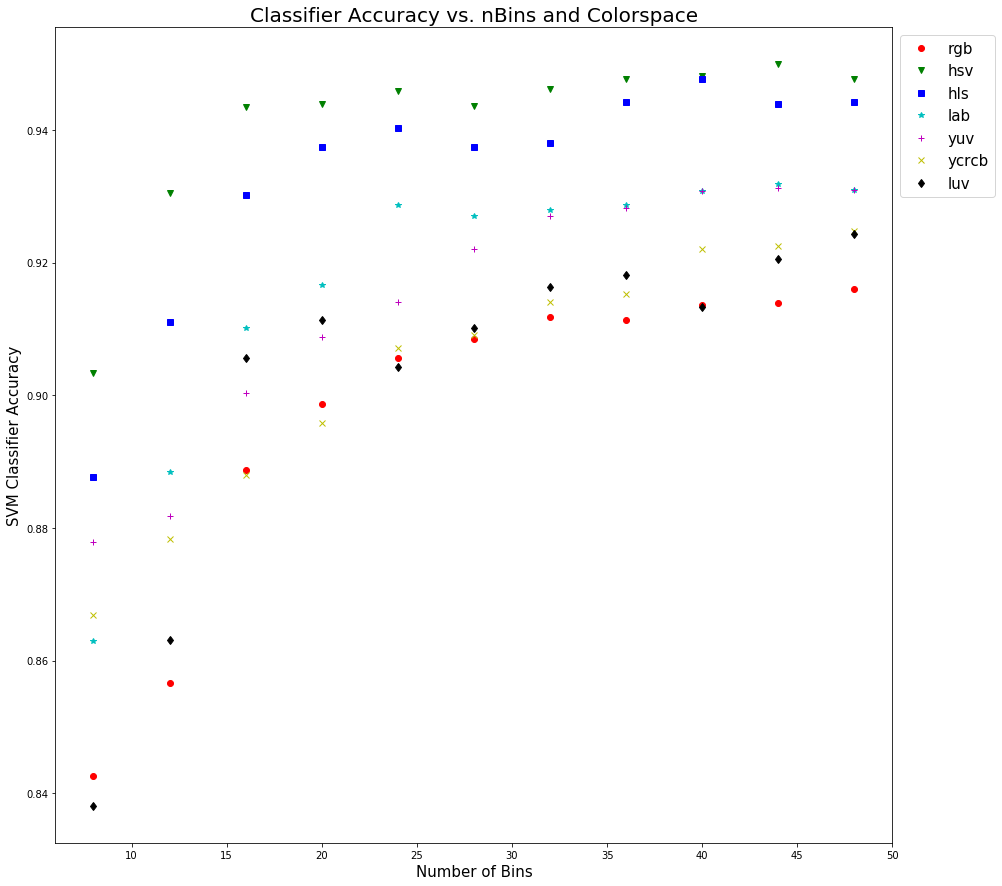

In [48]:
fig_2 = plt.figure(figsize=(15,15))

plot_style = ['or', 'vg', 'sb', '*c', '+m', 'xy', 'dk']

for i in range(len(colors)):
        plt.plot(bins, color_acc[i], plot_style[i], label = colors[i])
        
plt.legend(bbox_to_anchor=(1,1), loc=2, fontsize=15)
plt.ylabel("SVM Classifier Accuracy", fontsize=15)
plt.xlabel("Number of Bins", fontsize = 15)
plt.title("Classifier Accuracy vs. nBins and Colorspace", fontsize = 20)
plt.savefig("output_images/colorspace_historgram.png")
plt.show()



In [4]:
def bin_spatial(img, color_space='rgb', size=(32, 32)):
    # Convert image to new color space (if specified)
    if colorspace == 'rgb':
        img = img
    elif colorspace == 'hsv':
        img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    elif colorspace == 'hls':
        img = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    elif colorspace == 'lab':
        img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    elif colorspace == 'yuv':
        img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    elif colorspace == 'ycrcb':
        img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    elif colorspace == 'luv':
        img = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)      

    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

def bin_spatial_nc(img, size=(16,16)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

def bin_spatial_bulk(images, colorspace='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    
    feature_list = []
    counter = 1
    n_imgs = len(images)
    
    for img in images:
        if colorspace == 'rgb':
            img = img
        elif colorspace == 'hsv':
            img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        elif colorspace == 'hls':
            img = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        elif colorspace == 'lab':
            img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        elif colorspace == 'yuv':
            img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
        elif colorspace == 'ycrcb':
            img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        elif colorspace == 'luv':
            img = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)      

        # Use cv2.resize().ravel() to create the feature vector
        feature_list.append(cv2.resize(img, size).ravel())
        if (counter%10==0):
            sys.stdout.write("\rExtracting features for image %i of %i" % (counter, n_imgs))
            sys.stdout.flush()
        counter += 1
    # Return the feature vector
    return feature_list

In [58]:
colors = ['rgb', 'hsv', 'hls', 'lab', 'yuv', 'ycrcb', 'luv']
sizes = [(64,64), (32,32), (16,16), (8,8)]
size_labels = ['64x64', '32x32', '16x16', '8x8']
size_plot_label = [64, 32, 16, 8]

colorspace_acc = []
for color in colors:
    
    size_acc = []
    
    for size in sizes:
        car_features = bin_spatial_bulk(car_images, colorspace=color, size = size)
        non_car_features = bin_spatial_bulk(non_car_images, colorspace=color, size = size)

        X = np.vstack((car_features, non_car_features)).astype(np.float64)
        y = np.hstack((np.ones(len(car_features)), np.zeros(len(non_car_features))))

        X_scaler_spatial = StandardScaler().fit(X)
        scaled_X_spatial = X_scaler_spatial.transform(X)

        X_train, X_valid, y_train, y_valid = train_test_split(scaled_X_spatial, y, test_size=0.2, random_state =15)

        svc_spatial = LinearSVC()
        svc_spatial.fit(X_train, y_train)
        score_spatial = svc_spatial.score(X_valid, y_valid)
        size_acc.append(score_spatial)
        print("--")
        print("For colorspace:", color, "and size value:" , size)
        print("SVC accuracy is:", score_spatial)
        print("-------------------------------------------")
    
    colorspace_acc.append(size_acc)

spatial_accuracy = {"spatial_acc" : colorspace_acc}
pickle.dump(spatial_accuracy, open("pickles/spatial_accuracy.p", "wb"))


Extracting features for image 8960 of 8968--
For colorspace: rgb and size value: (64, 64)
SVC accuracy is: 0.905123873874
-------------------------------------------
Extracting features for image 8960 of 8968--
For colorspace: rgb and size value: (32, 32)
SVC accuracy is: 0.907094594595
-------------------------------------------
Extracting features for image 8960 of 8968--
For colorspace: rgb and size value: (16, 16)
SVC accuracy is: 0.92652027027
-------------------------------------------
Extracting features for image 8960 of 8968--
For colorspace: rgb and size value: (8, 8)
SVC accuracy is: 0.904560810811
-------------------------------------------
Extracting features for image 8960 of 8968--
For colorspace: hsv and size value: (64, 64)
SVC accuracy is: 0.880349099099
-------------------------------------------
Extracting features for image 8960 of 8968--
For colorspace: hsv and size value: (32, 32)
SVC accuracy is: 0.882038288288
-------------------------------------------
Extract

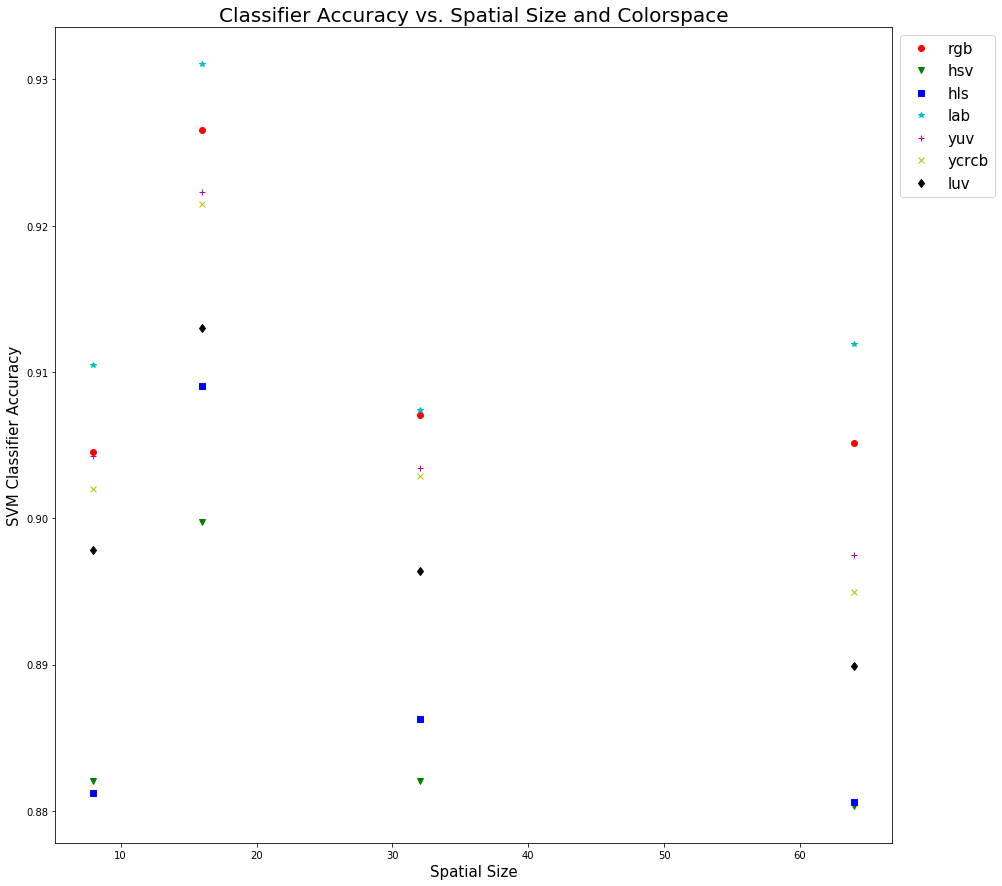

In [59]:
fig_8 = plt.figure(figsize=(15,15))

plot_style = ['or', 'vg', 'sb', '*c', '+m', 'xy', 'dk']

for i in range(len(colors)):
        plt.plot(size_plot_label, colorspace_acc[i], plot_style[i], label = colors[i])
        
plt.legend(bbox_to_anchor=(1,1), loc=2, fontsize=15)
plt.ylabel("SVM Classifier Accuracy", fontsize=15)
plt.xlabel("Spatial Size", fontsize = 15)
plt.title("Classifier Accuracy vs. Spatial Size and Colorspace", fontsize = 20)
plt.savefig("output_images/spatial_historgram.png")
plt.show()

## HOG Exploration

In [5]:
def get_hog_features_basic(img, orient, pix_per_cell, cell_per_block, feature_vec=True):

    features = hog(img, orientations=orient, 
                   pixels_per_cell=(pix_per_cell, pix_per_cell),
                   cells_per_block=(cell_per_block, cell_per_block), 
                   transform_sqrt=False, 
                   visualise=False, feature_vector=feature_vec)
    return features


def get_hog_features(img, orient, pix_per_cell, cell_per_block, colorspace='rgb', channel='all', vis=False, feature_vec=True):
    
    if colorspace == 'rgb':
        img = img
    elif colorspace == 'hsv':
        img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    elif colorspace == 'hls':
        img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    elif colorspace == 'lab':
        img = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    elif colorspace == 'yuv':
        img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    elif colorspace == 'ycrcb':
        img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    elif colorspace == 'luv':
        img = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    elif colorspace == 'gray':
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    if channel == 'all':
        feature_list = []
        hog_image_list = []
        for i in range(img.shape[2]):

            img_channel = img[:,:,i]
            
            if vis == True:
                features, hog_image = hog(img_channel, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                      cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                      visualise=True, feature_vector=False)
                
                feature_list.append(features)
                hog_image_list.append(hog_image)
    
            else:      
                features = hog(img_channel, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                               cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                               visualise=False, feature_vector=feature_vec)
                feature_list += features
    
        if vis == True:    
            return feature_list, hog_image_list
        else:
            return feature_list
        
    else:
        img = img[:,:,channel]
    
        if vis == True:
            features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
            return features, hog_image
    
        else:      
            features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
            return features
        
def bulk_hog_features(images,  orient, pix_per_cell, cell_per_block, colorspace='rgb', channel='all', feature_vec=True):
    
    counter = 1
    n_imgs = len(images)
    
    all_features = []
    
    for img in images:
        
        if colorspace == 'rgb':
            img = img
        elif colorspace == 'hsv':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif colorspace == 'hls':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif colorspace == 'lab':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        elif colorspace == 'yuv':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif colorspace == 'ycrcb':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        elif colorspace == 'luv':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif colorspace == 'gray':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        if channel == 'all':
            img_features = []
            for i in range(img.shape[2]):

                img_channel = img[:,:,i]
   
                features = hog(img_channel, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                               cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                               visualise=False, feature_vector=feature_vec)
                img_features.append(features)

        else:
            img = img[:,:,channel]
            
            img_features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        
        all_features.append(np.ravel(img_features))
            
        sys.stdout.write("\rExtracting HOG features for image %i of %i" % (counter, n_imgs))
        sys.stdout.flush()
        
        counter += 1
        
    return all_features
            


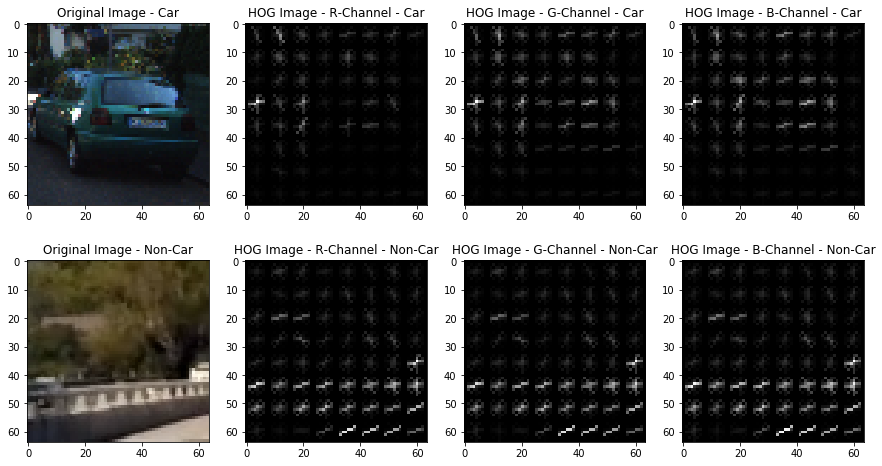

In [10]:
test_image_car = car_images[np.random.randint(0, len(car_images))]
test_image_noncar = non_car_images[np.random.randint(0, len(non_car_images))]

features_car, hog_image_car = get_hog_features(test_image_car, colorspace='rgb', channel='all', orient = 9, pix_per_cell = 8,
                                               cell_per_block=2,vis = True, feature_vec=True)

features_noncar, hog_image_noncar = get_hog_features(test_image_noncar, colorspace='rgb', channel='all', orient = 9, pix_per_cell = 8,
                                                     cell_per_block=2,vis = True, feature_vec=True)

fig_3 = plt.figure(figsize=(15,8))
fig_3.add_subplot(2,4,1)
plt.title('Original Image - Car')
plt.imshow(test_image_car)

fig_3.add_subplot(2,4,2)
plt.title('HOG Image - R-Channel - Car')
plt.imshow(hog_image_car[0], cmap='gray')

fig_3.add_subplot(2,4,3)
plt.title('HOG Image - G-Channel - Car')
plt.imshow(hog_image_car[1], cmap='gray')

fig_3.add_subplot(2,4,4)
plt.title('HOG Image - B-Channel - Car')
plt.imshow(hog_image_car[2], cmap='gray')

fig_3.add_subplot(2,4,5)
plt.title('Original Image - Non-Car')
plt.imshow(test_image_noncar)

fig_3.add_subplot(2,4,6)
plt.title('HOG Image - R-Channel - Non-Car')
plt.imshow(hog_image_noncar[0], cmap='gray')

fig_3.add_subplot(2,4,7)
plt.title('HOG Image - G-Channel - Non-Car')
plt.imshow(hog_image_noncar[1], cmap='gray')

fig_3.add_subplot(2,4,8)
plt.title('HOG Image - B-Channel - Non-Car')
plt.imshow(hog_image_noncar[2], cmap='gray')

plt.savefig('output_images/hog_vis.png')
plt.show()

In [2]:
hog_colors = ['rgb', 'hsv', 'hls', 'lab', 'yuv', 'ycrcb', 'luv']
hog_channels = [0, 1, 2, 'all']

hog_color_acc = []
for hog_color in hog_colors:
        
    hog_channel_acc = []
    for chan in hog_channels:
        
        car_hog_features = bulk_hog_features(car_images, colorspace=hog_color, channel=chan, orient = 9, pix_per_cell = 8,
                                      cell_per_block=2, feature_vec=True)
        non_car_hog_features = bulk_hog_features(non_car_images, colorspace=hog_color, channel=chan, orient = 9, pix_per_cell = 8,
                                      cell_per_block=2, feature_vec=True)
        
        X = np.vstack((car_hog_features, non_car_hog_features)).astype(np.float64)
        y = np.hstack((np.ones(len(car_hog_features)), np.zeros(len(non_car_hog_features))))
        
        X_scaler = StandardScaler().fit(X)
        scaled_X = X_scaler.transform(X)
        
        X_train, X_valid, y_train, y_valid = train_test_split(scaled_X, y, test_size=0.2, random_state =15)
                
        svc = LinearSVC()
        svc.fit(X_train, y_train)
        score = svc.score(X_valid, y_valid)
        hog_channel_acc.append(score)
        print("--")
        print("For colorspace:", hog_color, "and channel value:" , chan)
        print("SVC accuracy is:", score)
        print("-------------------------------------------")
    
    hog_color_acc.append(hog_channel_acc)

hog_color_accuracy = {"hog_color_acc" : hog_color_acc}
pickle.dump(hog_color_accuracy, open("pickles/hog_color_accuracy.p", "wb"))


NameError: name 'bulk_hog_features' is not defined

In [9]:
orients = [7, 9, 11, 13, 15, 17]
ppcs = [4, 8, 16]


ppc_acc = []

for ppc in ppcs:

    orient_acc = []

    for orient in orients:

        car_hog_features = bulk_hog_features(car_images, colorspace='yuv', channel='all', orient = orient, 
                                             pix_per_cell = ppc, cell_per_block=2, feature_vec=True)

        non_car_hog_features = bulk_hog_features(non_car_images, colorspace='yuv', channel='all', 
                                                 orient = orient, pix_per_cell = ppc, cell_per_block=2, 
                                                 feature_vec=True)

        X = np.vstack((car_hog_features, non_car_hog_features)).astype(np.float64)
        y = np.hstack((np.ones(len(car_hog_features)), np.zeros(len(non_car_hog_features))))

        X_scaler = StandardScaler().fit(X)
        scaled_X = X_scaler.transform(X)

        X_train, X_valid, y_train, y_valid = train_test_split(scaled_X, y, test_size=0.2, random_state =15)

        svc = LinearSVC()
        svc.fit(X_train, y_train)
        score = svc.score(X_valid, y_valid)
        orient_acc.append(score)
        print("--")
        print("For Pix Per Cell:" , ppc, 'and Orient:', orient, ':')
        print("SVC accuracy is:", score)
        print("-------------------------------------------")
        svc = None
        X_scaler = None
        car_hog_features = None
        non_car_hog_features = None
        X = None
        y=None
        X_valid = None
        y_valid= None
        score = None

    ppc_acc.append(orient_acc)


hog_param_accuracy = {"hog_yuv_acc" : ppc_acc}
pickle.dump(hog_param_accuracy, open("pickles/hog_yuv_accuracy_cpb_2.p", "wb"))

Extracting HOG features for image 8968 of 8968--
For Pix Per Cell: 4 and Orient: 7 :
SVC accuracy is: 0.98536036036
-------------------------------------------
Extracting HOG features for image 8968 of 8968--
For Pix Per Cell: 4 and Orient: 9 :
SVC accuracy is: 0.98704954955
-------------------------------------------
Extracting HOG features for image 8968 of 8968--
For Pix Per Cell: 4 and Orient: 11 :
SVC accuracy is: 0.987612612613
-------------------------------------------
Extracting HOG features for image 8968 of 8968--
For Pix Per Cell: 4 and Orient: 13 :
SVC accuracy is: 0.987894144144
-------------------------------------------
Extracting HOG features for image 8968 of 8968--
For Pix Per Cell: 4 and Orient: 15 :
SVC accuracy is: 0.990146396396
-------------------------------------------
Extracting HOG features for image 8968 of 8968--
For Pix Per Cell: 4 and Orient: 17 :
SVC accuracy is: 0.989301801802
-------------------------------------------
Extracting HOG features for imag

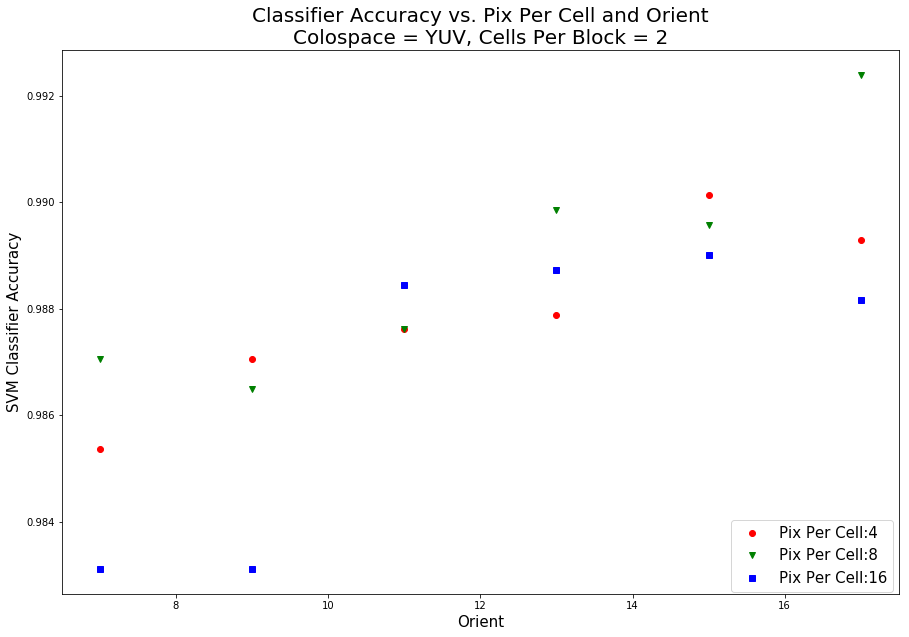

In [28]:
yuv_acc = pickle.load(open("pickles/hog_yuv_accuracy_cpb_2.p", "rb"))
ppc_acc = yuv_acc["hog_yuv_acc"]
orients = [7, 9, 11, 13, 15, 17]
ppcs = [4, 8, 16]
hog_param_fig = plt.figure(figsize=(15,10))
chans = [0, 1, 2, 3]

plot_style = ['or', 'vg', 'sb']

for i in range(len(ppcs)):
    plt.plot(orients, ppc_acc[i], plot_style[i], label = ('Pix Per Cell:' + str(ppcs[i])))

plt.legend(bbox_to_anchor=(0.79,0.15), loc=2, fontsize=15)
plt.ylabel("SVM Classifier Accuracy", fontsize=15)
plt.xlabel("Orient", fontsize = 15)
plt.title("Classifier Accuracy vs. Pix Per Cell and Orient\nColospace = YUV, Cells Per Block = 2", fontsize = 20)   

hog_param_fig
plt.savefig("output_images/hog_yuv_cpb_2.png")
plt.show()

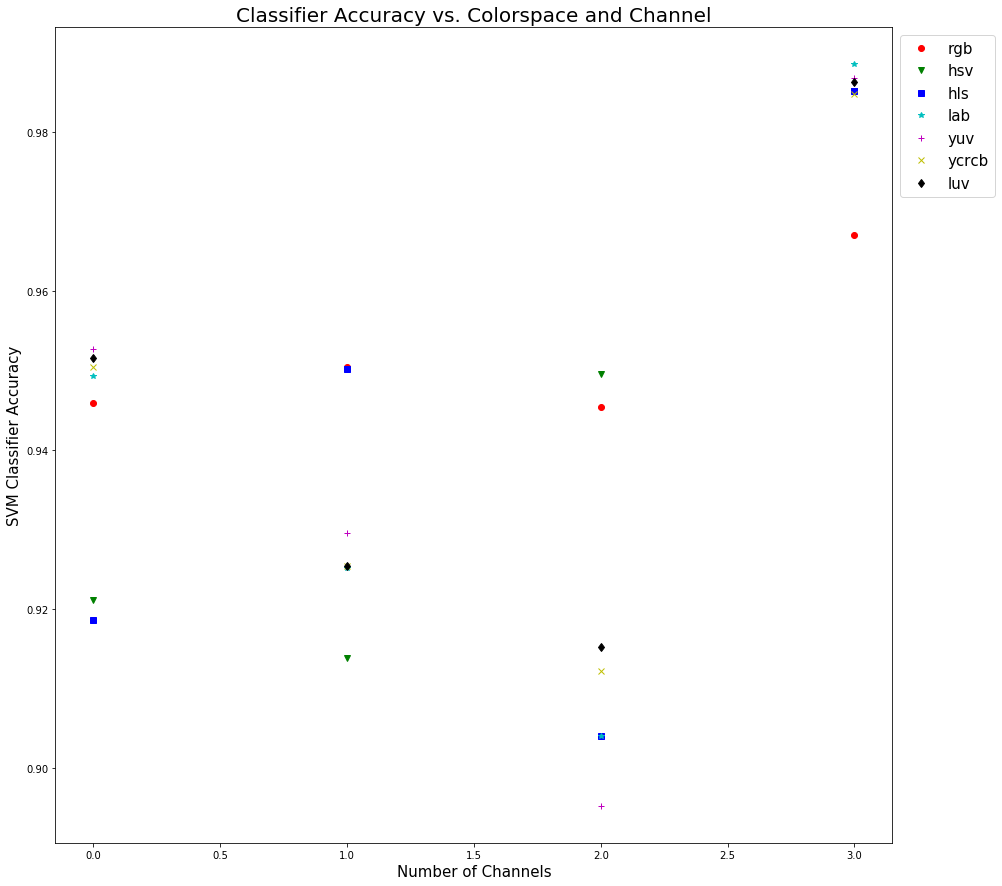

In [157]:
fig_4 = plt.figure(figsize=(15,15))
chans = [0, 1, 2, 3]

plot_style = ['or', 'vg', 'sb', '*c', '+m', 'xy', 'dk']

for i in range(len(hog_colors) -1):
        plt.plot(chans, hog_color_acc[i], plot_style[i], label = hog_colors[i])
        
plt.legend(bbox_to_anchor=(1,1), loc=2, fontsize=15)
plt.ylabel("SVM Classifier Accuracy", fontsize=15)
plt.xlabel("Number of Channels", fontsize = 15)
plt.title("Classifier Accuracy vs. Colorspace and Channel", fontsize = 20)
plt.savefig("output_images/hog_historgram.png")
plt.show()

## Parameter Tuning

In [8]:
def extract_all_features(images, orient, pix_per_cell, cell_per_block, spatial_size = (16,16), hog_channel='all', 
                         feature_vec=True, nbins=32, bins_range=(0, 256)):
    
    counter = 1
    n_imgs = len(images)
    
    all_features = []
    
    for image in images:
        image_lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
        image_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            
        spatial_features = cv2.resize(image_lab, spatial_size).ravel()
        
        ch1 = np.histogram(image_hsv[:,:,0], bins=nbins, range=bins_range)
        ch2 = np.histogram(image_hsv[:,:,1], bins=nbins, range=bins_range)
        ch3 = np.histogram(image_hsv[:,:,2], bins=nbins, range=bins_range)
    
        # Concatenate the histograms into a single feature vector
        hist_features = np.concatenate((ch1[0], ch2[0], ch3[0]))

        if hog_channel == 'all':
            img_features = []
            for i in range(image.shape[2]):

                img_channel = image_hsv[:,:,i]
   
                features = hog(img_channel, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                               cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                               visualise=False, feature_vector=feature_vec)
                img_features.append(features)

        else:
            img = image_hsv[:,:,hog_channel]
            
            img_features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        
        added_features = np.concatenate((spatial_features, hist_features, np.ravel(img_features)))
        all_features.append(added_features)
            
        sys.stdout.write("\rExtracting HOG features for image %i of %i" % (counter, n_imgs))
        sys.stdout.flush()
        
        counter += 1
        
    return all_features

In [7]:


car_features = extract_all_features(car_images, orient=9, pix_per_cell = 8, cell_per_block = 2, 
                                    spatial_size = (16,16), hog_channel='all', feature_vec=True, nbins=40, 
                                    bins_range=(0, 256))

non_car_features = extract_all_features(non_car_images, orient=9, pix_per_cell = 8, cell_per_block = 2, 
                                        spatial_size = (16,16), hog_channel='all', feature_vec=True, nbins=40, 
                                        bins_range=(0, 256))

X = np.vstack((car_features, non_car_features)).astype(np.float64)
y = np.hstack((np.ones(len(car_features)), np.zeros(len(non_car_features))))

final_X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

X_train, X_valid, y_train, y_valid = train_test_split(scaled_X, y, test_size=0.2, random_state =8)

parameters = {'loss': ('hinge', 'squared_hinge'), 'C':[0.1, 1.0, 5.0, 10.0]}
final_svc = LinearSVC()
#clf = grid_search.GridSearchCV(svc, parameters)
final_svc.fit(X_train, y_train)
final_score = final_svc.score(X_valid, y_valid)
print('\n')
print('The score is:', final_score)

classifier = {"svc":final_svc,
               "X_scaler":final_X_scaler}
pickle.dump(classifier, open("classifier.p", "wb"))

NameError: name 'extract_all_features' is not defined

## Sliding Window Search

In [30]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


def draw_boxes(img, bboxes, thick=6):
    # Make a copy of the image
    draw_img = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        c1 = np.random.randint(0,255)
        c2 = np.random.randint(0,255)
        c3 = np.random.randint(0,255)
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(draw_img, bbox[0], bbox[1], (c1,c2,c3), thick)
    # Return the image copy with boxes drawn
    return draw_img


There are: 92 large windows
There are: 259 medium windows


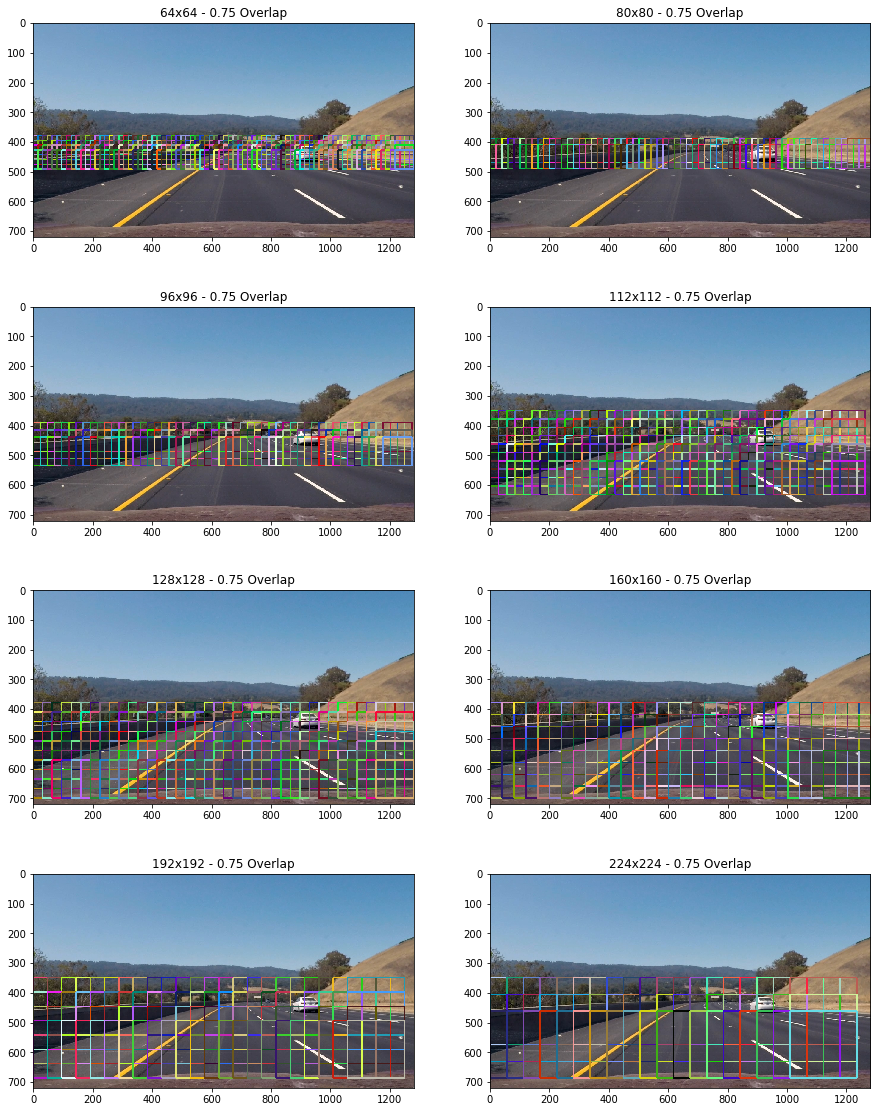

In [38]:
test_files = glob.glob('test_images/*.jpg')
test_images = []

for file in test_files:
    test_images.append(cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB))

xl_windows = slide_window(test_images[5], x_start_stop=[None, None], y_start_stop=[350, 720], 
                        xy_window=(224, 224), xy_overlap = (0.75, 0.75))

large_windows = slide_window(test_images[5], x_start_stop=[None, None], y_start_stop=[350, 720],
                        xy_window=(192, 192), xy_overlap = (0.75, 0.75))

med_large_windows = slide_window(test_images[5], x_start_stop=[None, None], y_start_stop=[380, 720], 
                        xy_window=(160, 160), xy_overlap = (0.75, 0.75))
    
medium_windows = slide_window(test_images[5], x_start_stop=[None, None], y_start_stop=[380, 720], 
                        xy_window=(128, 128), xy_overlap = (0.75, 0.75))

med_small_windows = slide_window(test_images[5], x_start_stop=[None, None], y_start_stop=[350,630], 
                        xy_window=(112, 112), xy_overlap = (0.75, 0.75))

small_windows = slide_window(test_images[5], x_start_stop=[None, None], y_start_stop=[390, 550], 
                        xy_window=(96, 96), xy_overlap = (0.75, 0.75))

xs_windows = slide_window(test_images[5], x_start_stop=[None, None], y_start_stop=[390, 500], 
                        xy_window=(80, 80), xy_overlap = (0.75, 0.75))

xxs_windows = slide_window(test_images[5], x_start_stop=[None, None], y_start_stop=[380, 500], 
                        xy_window=(64, 64), xy_overlap = (0.75, 0.75))

window_xxs = draw_boxes(test_images[5], xxs_windows, thick=3)
window_xs = draw_boxes(test_images[5], xs_windows, thick=3)
window_small = draw_boxes(test_images[5], small_windows, thick=3)
window_med_small = draw_boxes(test_images[5], med_small_windows, thick=3)
window_medium = draw_boxes(test_images[5], medium_windows, thick=3)
window_med_large = draw_boxes(test_images[5], med_large_windows, thick=3)
window_large = draw_boxes(test_images[5], large_windows, thick=3)
window_xl = draw_boxes(test_images[5], xl_windows, thick=3)

print('There are:', len(large_windows), 'large windows')
print('There are:', len(medium_windows), 'medium windows')

fig_5 = plt.figure(figsize=(15,20))

fig_5.add_subplot(4,2,1)
plt.title('64x64 - 0.75 Overlap')
plt.imshow(window_xxs)

fig_5.add_subplot(4,2,2)
plt.title('80x80 - 0.75 Overlap')
plt.imshow(window_xs)

fig_5.add_subplot(4,2,3)
plt.title('96x96 - 0.75 Overlap')
plt.imshow(window_small)

fig_5.add_subplot(4,2,4)
plt.title('112x112 - 0.75 Overlap')
plt.imshow(window_med_small)

fig_5.add_subplot(4,2,5)
plt.title('128x128 - 0.75 Overlap')
plt.imshow(window_medium)

fig_5.add_subplot(4,2,6)
plt.title('160x160 - 0.75 Overlap')
plt.imshow(window_med_large)

fig_5.add_subplot(4,2,7)
plt.title('192x192 - 0.75 Overlap')
plt.imshow(window_large)

fig_5.add_subplot(4,2,8)
plt.title('224x224 - 0.75 Overlap')
plt.imshow(window_xl)
plt.savefig('output_images/sliding_windows')
plt.show()